# Importing Libraries

In [1]:
from tensorflow.keras.applications import VGG16
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
import json
import math

ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

# Classifying an input using VGG 16

In [17]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

In [18]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [19]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count, 1))
    #labels = np.zeros(shape = (sample_count, 2)) edited to two as my custom image directory has only two classes.
    generator = datagen.flow_from_directory(directory, target_size = (150, 150), batch_size = batch_size, class_mode="categorical",subset = "training")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [20]:
test_dir = 'DemoImg/Test'

In [2]:
model = load_model('Models/YogaPoseClassifierRegularCustomDB.h5')

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 2,098,693
Trainable params: 2,098,693
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [22]:
test_features, test_labels = extract_features(test_dir, 1)

Found 1 images belonging to 1 classes.


In [23]:
test_features = np.reshape(test_features, (1, 4 * 4 * 512))

In [24]:
output_class = model.predict(test_features)

In [25]:
print(output_class)

[[0.00779334 0.00659276 0.00771177 0.00233    0.9755721 ]]


In [26]:
poses = ['Goddess', 'Half Moon', 'Tree', 'Triangle', 'Warrior2']

In [27]:
def output_pose(array):
    max_val = max(array)
    pos = -1
    for i, val in enumerate(array):
        if val == max_val:
            pos = i
            break
    return poses[pos]

In [28]:
input_pose = []
for output in output_class:
    input_pose_curr = (output_pose(output))
    input_pose.append(input_pose_curr)
print(input_pose)    

['Warrior2']


# Scoring The Pose

In [29]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "Term 2 Journal Testing/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "Term 2 Journal Testing/pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

In [30]:
f = open("AngleValues/angles.json")
angle_dict = json.load(f)
f = open("AngleValues/poseIndices.json")
pose_indices_dict = json.load(f)

In [31]:
img_address = []
for img in os.listdir(test_dir + '/Test'):
    img_address.append(test_dir + '/Test/' + img)
print(img_address)

['DemoImg/Test/Test/.ipynb_checkpoints', 'DemoImg/Test/Test/00000147.jpg']


In [34]:
temp_img = img_address[1]
img_address = []
img_address.append(temp_img)

In [35]:
img_address

['DemoImg/Test/Test/00000147.jpg']

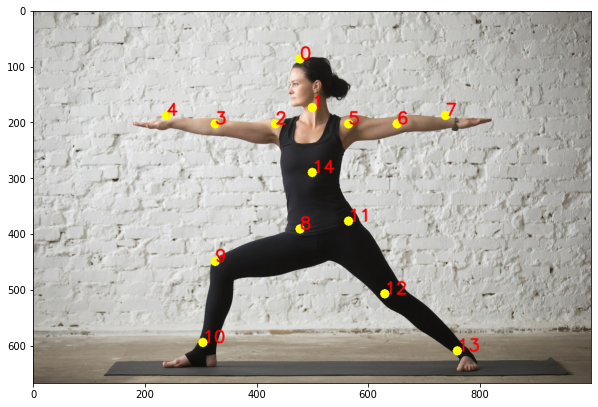

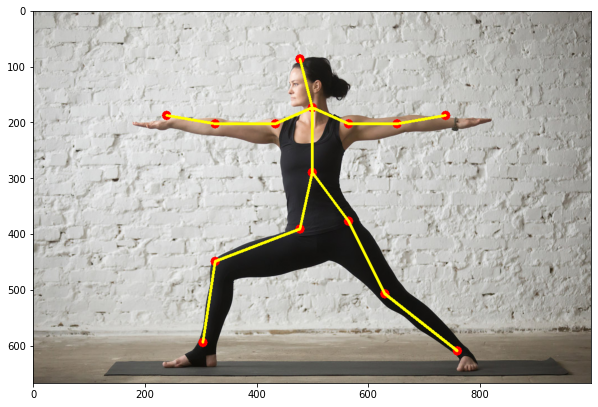

In [36]:
pose_coordinates = []
for img in img_address:
    frame = cv2.imread(img)
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]
    points = []
    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)
        
    pose_coordinates.append(points)
    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [37]:
def calculate_angle(indices, coordinates):
    p1 = coordinates[indices[0]]
    p2 = coordinates[indices[1]]
    p3 = coordinates[indices[2]]
    if(p3[0] - p2[0] == 0 and p2[0] - p1[0] == 0):
        return 0
    if(p2[0] - p1[0] == 0):
        m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
        return (90 - math.degrees(math.atan(m2)))
    if(p3[0] - p2[0] == 0):
        m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
        return (90 - math.degrees(math.atan(m1)))
    m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
    m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
    if(m1 * m2 == -1):
        theta = 90
    else:
        tan_theta = (m2-m1)/(1 + m1 * m2)
        theta = math.degrees(math.atan(tan_theta))
    return theta

In [38]:
store_dict = {}
for k in  pose_indices_dict:
    store_dict[k] = calculate_angle(pose_indices_dict[k], pose_coordinates[0])        
print(store_dict)

{'elbow-l': 9.782407031807287, 'elbow-r': -9.782407031807287, 'knee-l': -60.48684539524172, 'knee-r': -25.316672453558965, 'kneck-l': 80.47070097671939, 'kneck-r': -51.7646801816082, 'leg-l': 56.825875376031625, 'leg-r': 10.199329498712508, 'back': 14.191096549023968}


In [39]:
for joint in store_dict:
    if abs(store_dict[joint]) > 90:
        store_dict[joint] = 180 - abs(store_dict[joint])

In [40]:
diff_matrix = []
for ip in input_pose:
    diff_matrix_curr = []
    for joint in store_dict:
        diff_matrix_curr.append(abs(abs(angle_dict[ip][joint]) - abs(store_dict[joint])))
    diff_matrix.append(diff_matrix_curr)

In [41]:
diff_matrix[0]

[2.3509990606347797,
 9.782407031807287,
 6.314564091110093,
 12.329753344666454,
 33.92254327774141,
 14.272830843813622,
 20.16585144175515,
 3.465795525230117,
 3.783385236533917]

In [42]:
angle_dict['Warrior2']

{'elbow-l': -7.431407971172507,
 'elbow-r': 0.0,
 'knee-l': 66.80140948635182,
 'knee-r': -12.986919108892511,
 'kneck-l': 46.548157698977974,
 'kneck-r': 66.03751102542182,
 'leg-l': 36.660023934276474,
 'leg-r': -13.665125023942625,
 'back': 10.40771131249005}

In [46]:
store_dict

{'elbow-l': 9.782407031807287,
 'elbow-r': -9.782407031807287,
 'knee-l': -60.48684539524172,
 'knee-r': -25.316672453558965,
 'kneck-l': 80.47070097671939,
 'kneck-r': -51.7646801816082,
 'leg-l': 56.825875376031625,
 'leg-r': 10.199329498712508,
 'back': 14.191096549023968}

In [44]:
diff_avg = sum(diff_matrix[0])/len(diff_matrix[0])
print(diff_avg)

11.820903317032538


In [45]:
if diff_avg < 5:
    print(10)
elif diff_avg < 10:
    print(9)
elif diff_avg < 15:
    print(8)
elif diff_avg < 20:
    print(7)
else:
    print("Please make a better attempt !")

8
